Flipping detection

In [ ]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1uJ-dv3bs5iCgEgIe3dILw7kEhAktldzz' 
#import image files from Google Drive

download = drive.CreateFile({'id': file_id})


# Download the file to a local disc
download.GetContentFile('images.zip')

In [ ]:
from zipfile import ZipFile
with ZipFile('images.zip', 'r') as zipImage:
    zipImage.extractall()


In [ ]:

import pandas as pd
import os
import numpy as np
folder_path = os.getcwd() + '/images/'
if not os.path.exists(folder_path):
    os.mkdir(folder_path)

In [ ]:
os.getcwd()

'/content'

Data Preprocessing

Before we start our training on the image model, we need to preprocess our data. Images are transformed into standard form with normalized RGB colour and size of 256x256, and then convert to Tensor

In [ ]:

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageFile
from sklearn.metrics import classification_report,confusion_matrix
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224), #299 for inception 224 for others
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

seed = 1
num_classes = 2

In [ ]:
#Dataframes are created for train set and test set
column_list = ['Image_Path', 'Flip']
df_train, df_test = pd.DataFrame(columns= column_list), pd.DataFrame(columns= column_list)

In [ ]:
for folder in os.listdir(folder_path):
    print(folder)
    if folder =='training':
        print(os.path.join(folder_path, folder, ""))
        for train_folder in os.listdir(os.path.join(folder_path, folder)):                                      
            for pic in os.listdir(os.path.join(folder_path, folder, train_folder, "")):
                current_path = os.path.join(folder_path, folder, train_folder, "")
                image_path = current_path + pic 
                print(image_path)
                if train_folder == 'flip':
                    ground_truth = 1
                else: ground_truth = 0
                new_row = {'Image_Path': image_path, 'Flip': ground_truth}
                df_train = df_train.append(new_row, ignore_index=True)
                print(new_row)
    elif folder =='testing':
        for test_folder in os.listdir(os.path.join(folder_path, folder)):                                      
            for pic in os.listdir(os.path.join(folder_path, folder, test_folder, "")):
                current_path = os.path.join(folder_path, folder, test_folder, "")
                image_path = current_path + pic 
                print(image_path)
                if test_folder == 'flip':
                    ground_truth = 1
                else: ground_truth = 0
                new_row = {'Image_Path': image_path, 'Flip': ground_truth}
                df_test = df_test.append(new_row, ignore_index=True)

In [ ]:
df_train['img_encode'] = df_train['Image_Path'].apply(lambda x: preprocess(Image.open(x)).unsqueeze(0))
df_test['img_encode'] = df_test['Image_Path'].apply(lambda x: preprocess(Image.open(x)).unsqueeze(0))



Let's examine the trainset and test set. Both sets contain similar size of flipped and not flipped images. Therefore, the both sets are considered balanced. 

In [ ]:

print('The number of sample in train set:', len(df_train))
print('The number of sample in test set:', len(df_test))
print('The number of images not flipped in train set:', len(df_train[df_train['Flip']==0]))
print('The number of flipped images in train set:', len(df_train[df_train['Flip']==1]))
print('The number of images not flipped in test set:', len(df_test[df_test['Flip']==0]))
print('The number of flipped images in test set:', len(df_test[df_test['Flip']==1]))

The number of sample in train set: 2392
The number of sample in test set: 597
The number of images not flipped in train set: 1230
The number of flipped images in train set: 1162
The number of images not flipped in test set: 307
The number of flipped images in test set: 290


In [ ]:
df_train['Flip'].value_counts()

0    1230
1    1162
Name: Flip, dtype: int64

In [ ]:
#The validation set is also created for parameter tuning
new_df_train = df_train.sample(frac = 0.8, random_state=seed)

new_df_val = df_train.drop(new_df_train.index)

df_train = new_df_train
df_val = new_df_val

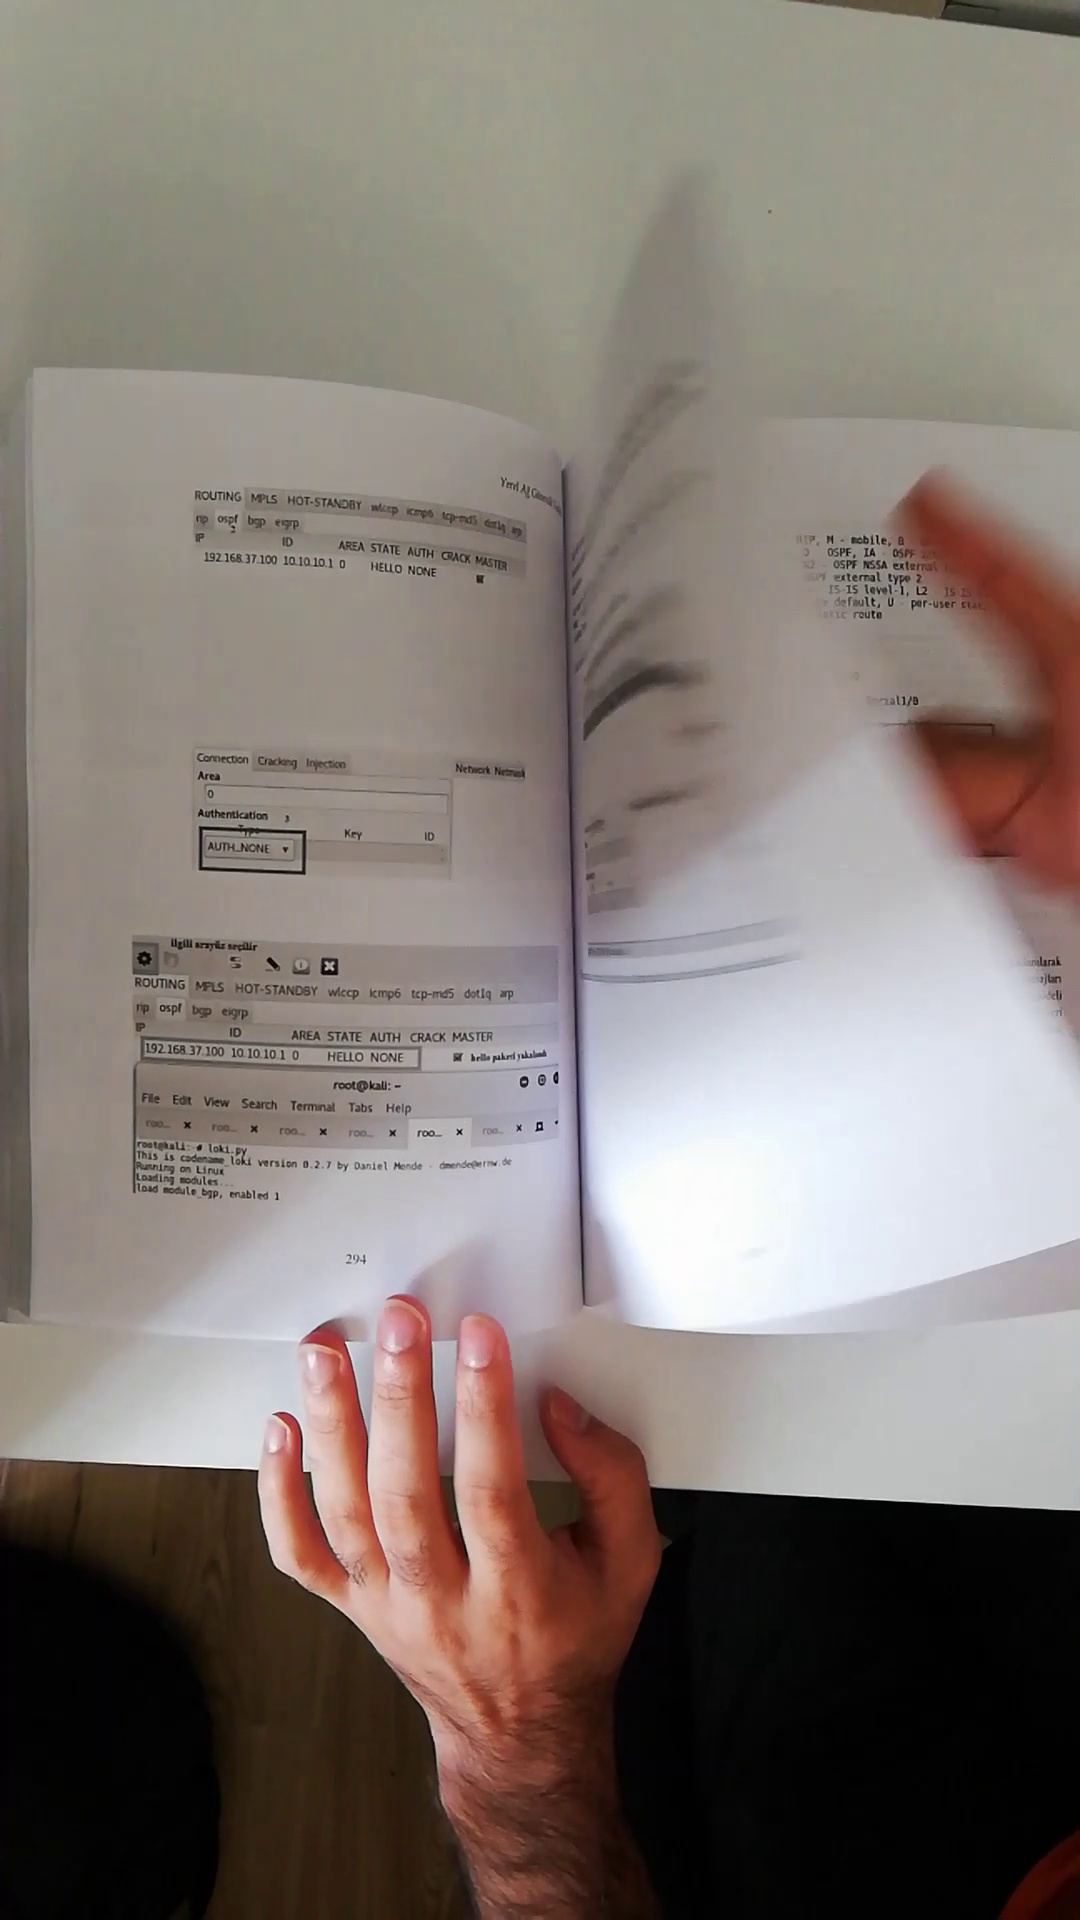

torch.Size([1, 3, 224, 224])


In [ ]:
#Let's check an image in the train set and it's size after transformed
im = Image.open(df_train.iloc[70]['Image_Path'])

input_i = preprocess(im).unsqueeze(0).to(device)
display(im)
print(input_i.shape)


#DataLoader and Dataset

A DataLoader and Dataset is created for the iterable over the given dataset

In [ ]:

from torch.utils.data import Dataset, DataLoader


class Image_Dataset(Dataset):
    def __init__(self, df):

        self.image_file = df



    def __len__(self):
        return len(self.image_file)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.image_file.iloc[idx, 2]

        answer = self.image_file.iloc[idx, 1]

        sample = {'image': image, 'flip': answer}

        return sample

In [ ]:
#We created 3 dataset with batch size of 32 for train set, val set and test set using the dataloader above.
BATCH_SIZE = 32

train_dataloader = DataLoader(Image_Dataset(df_train), 
                              batch_size=BATCH_SIZE, shuffle = True, pin_memory=True)

test_dataloader = DataLoader(Image_Dataset(df_test), 
                              batch_size=BATCH_SIZE, shuffle = True, pin_memory=True)

val_dataloader = DataLoader(Image_Dataset(df_val), 
                              batch_size=BATCH_SIZE, shuffle = True, pin_memory=True)

In [ ]:
idx, batch = next(enumerate(train_dataloader))
print(batch['image'])
print(batch['flip'])

ResNet

In this project, we use ResNet for the image classification task. ResNet is a pre-trained model for image classification tasks. 
It is a model that contains very deep feedforward neural network with hundreds of layers.
We use the architecture of the ResNet model and change the number of the output in the last layer. This is a transfer learning technic that can reduce our training comsumption and benefit from previous training effort
Two ResNet models are selected, ResNet18 and ResNet50, 18 and 50 represent the number of layers respectively.

In [ ]:

import torch
from torchvision import models
model_resnet18 = models.resnet18(pretrained=True)
model_resnet50 = models.resnet50(pretrained=True)



Since we just want to fine tune the model, we keep all other parameter except the parameter of the last layer non-trainable.
It can save a lot of computing resource and time to train the model and preserve the predictive power from the pre-trained parameter.


In [ ]:


for param in model_resnet18.parameters():
    param.requires_grad = False

for param in model_resnet50.parameters():
    param.requires_grad = False

model_resnet18.fc = nn.Linear(512, num_classes) #For Resnet18
model_resnet50.fc = nn.Linear(2048, num_classes) # for Resnet50

for parameter in model_resnet18.parameters(): 
     print(parameter, parameter.requires_grad)

We create functions to save the parameters of the best model and evaluate the model performance during training

In [ ]:


from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import copy

def save_model(model):
    PATH = os.getcwd() + 'best_model.pt'
    torch.save({
            'model_state_dict': model.state_dict()
            }, PATH)
    
def evaluate(model, dataloader, return_prediction = False):
    model.to(device)
    model.eval()
    predictions = None
    torch.cuda.empty_cache()
    
    for idx, batch in tqdm(enumerate(dataloader)):   
           
        img = batch['image'].squeeze(1).to(device)
        ground_turth = batch['flip']
        prediction = model(img)

        if predictions is not None:
            prediction = prediction.detach().cpu().numpy()
            predictions = np.append(predictions, np.argmax(prediction, axis=1))
            ground_turths = np.append(ground_turths, ground_turth.detach().cpu().numpy())
        else:
            predictions = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            ground_turths = ground_turth.detach().cpu().numpy()
    f1_score_pred = f1_score(predictions, ground_turths) #F1 score is used to evaluate the performance
    acc = accuracy_score(predictions, ground_turths)
    print("Accuracy:", acc, ',F1 Score:', f1_score_pred)
    if return_prediction == False:
        return(acc)
    else:
        return(acc, predictions, ground_turths)

We use Adam for optimizer and learning rate 0.0005. Because this is model with pre-trained parameters, we do not need to train the model for many epochs.
We choose to fine tune the model for 50 epochs since the model is converging quickly

In [ ]:


criterion = nn.CrossEntropyLoss()
optimizer_Resnet18 = torch.optim.Adam(model_resnet18.parameters(), lr=0.0005)
optimizer_Resnet50 = torch.optim.Adam(model_resnet50.parameters(), lr=0.0005)

def train_model(model, criterion, optimizer, num_epochs=50):

    model.to(device)
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        model.train()

        for idx, batch in tqdm(enumerate(train_dataloader)):
        
            epoch_loss = 0.0
            img = batch['image'].squeeze(1).to(device)
            ground_turth = batch['flip'].to(device)


            optimizer.zero_grad()

            prediction = model(img)

            #print(prediction.shape, ground_turth.shape)
            loss = criterion(prediction, ground_turth)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
        print('Epoch loss is:', epoch_loss)
        accuracy = evaluate(model, val_dataloader)

        if accuracy > best_accuracy:
            best_model_wts = copy.deepcopy(model.state_dict())
            save_model(model)
            best_accuracy = accuracy
            print('New best accuracy!')
        print('\n')



In [ ]:
train_model(model_resnet18, criterion, optimizer_Resnet18, num_epochs=50)

Epoch 1/50
----------


60it [00:07,  7.60it/s]


Epoch loss is: 0.5962485074996948


15it [00:00, 31.55it/s]


Accuracy: 0.803347280334728 ,F1 Score: 0.8097165991902834
New best accuracy!


Epoch 2/50
----------


60it [00:01, 33.51it/s]


Epoch loss is: 0.27712371945381165


15it [00:00, 34.97it/s]


Accuracy: 0.8305439330543933 ,F1 Score: 0.8
New best accuracy!


Epoch 3/50
----------


60it [00:01, 33.78it/s]


Epoch loss is: 0.36914852261543274


15it [00:00, 35.35it/s]


Accuracy: 0.8577405857740585 ,F1 Score: 0.8682170542635659
New best accuracy!


Epoch 4/50
----------


60it [00:01, 33.86it/s]


Epoch loss is: 0.4373525381088257


15it [00:00, 34.98it/s]


Accuracy: 0.9016736401673641 ,F1 Score: 0.9026915113871636
New best accuracy!


Epoch 5/50
----------


60it [00:01, 33.85it/s]


Epoch loss is: 0.261512815952301


15it [00:00, 35.40it/s]


Accuracy: 0.899581589958159 ,F1 Score: 0.9036144578313253


Epoch 6/50
----------


60it [00:01, 33.30it/s]


Epoch loss is: 0.2575245499610901


15it [00:00, 35.02it/s]


Accuracy: 0.8807531380753139 ,F1 Score: 0.8646080760095011


Epoch 7/50
----------


60it [00:01, 33.77it/s]


Epoch loss is: 0.21892286837100983


15it [00:00, 35.03it/s]


Accuracy: 0.9225941422594143 ,F1 Score: 0.9207708779443254
New best accuracy!


Epoch 8/50
----------


60it [00:01, 33.56it/s]


Epoch loss is: 0.21723255515098572


15it [00:00, 34.28it/s]


Accuracy: 0.9058577405857741 ,F1 Score: 0.8988764044943819


Epoch 9/50
----------


60it [00:01, 34.08it/s]


Epoch loss is: 0.17868994176387787


15it [00:00, 35.43it/s]


Accuracy: 0.9225941422594143 ,F1 Score: 0.9183222958057395


Epoch 10/50
----------


60it [00:01, 33.93it/s]


Epoch loss is: 0.1888934075832367


15it [00:00, 35.05it/s]


Accuracy: 0.9309623430962343 ,F1 Score: 0.929936305732484
New best accuracy!


Epoch 11/50
----------


60it [00:01, 33.96it/s]


Epoch loss is: 0.2995302975177765


15it [00:00, 34.94it/s]


Accuracy: 0.9393305439330544 ,F1 Score: 0.9384288747346072
New best accuracy!


Epoch 12/50
----------


60it [00:01, 33.49it/s]


Epoch loss is: 0.19640865921974182


15it [00:00, 35.86it/s]


Accuracy: 0.9351464435146444 ,F1 Score: 0.9336188436830835


Epoch 13/50
----------


60it [00:01, 33.88it/s]


Epoch loss is: 0.32011857628822327


15it [00:00, 35.25it/s]


Accuracy: 0.9288702928870293 ,F1 Score: 0.9251101321585903


Epoch 14/50
----------


60it [00:01, 33.96it/s]


Epoch loss is: 0.2675686478614807


15it [00:00, 35.71it/s]


Accuracy: 0.9351464435146444 ,F1 Score: 0.9318681318681319


Epoch 15/50
----------


60it [00:01, 33.77it/s]


Epoch loss is: 0.4660989046096802


15it [00:00, 34.97it/s]


Accuracy: 0.9309623430962343 ,F1 Score: 0.9268292682926829


Epoch 16/50
----------


60it [00:01, 33.90it/s]


Epoch loss is: 0.17468096315860748


15it [00:00, 35.00it/s]


Accuracy: 0.9225941422594143 ,F1 Score: 0.9160997732426304


Epoch 17/50
----------


60it [00:01, 33.90it/s]


Epoch loss is: 0.11606347560882568


15it [00:00, 34.75it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.939655172413793
New best accuracy!


Epoch 18/50
----------


60it [00:01, 33.54it/s]


Epoch loss is: 0.29307958483695984


15it [00:00, 34.92it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.9388646288209607


Epoch 19/50
----------


60it [00:01, 33.10it/s]


Epoch loss is: 0.2237672060728073


15it [00:00, 34.87it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.939655172413793


Epoch 20/50
----------


60it [00:01, 33.85it/s]


Epoch loss is: 0.28823381662368774


15it [00:00, 35.40it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.9388646288209607


Epoch 21/50
----------


60it [00:01, 33.74it/s]


Epoch loss is: 0.22362519800662994


15it [00:00, 35.02it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.9391304347826087


Epoch 22/50
----------


60it [00:01, 33.60it/s]


Epoch loss is: 0.10512468218803406


15it [00:00, 35.55it/s]


Accuracy: 0.9393305439330544 ,F1 Score: 0.9359823399558499


Epoch 23/50
----------


60it [00:01, 33.91it/s]


Epoch loss is: 0.12107466161251068


15it [00:00, 35.31it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.9388646288209607


Epoch 24/50
----------


60it [00:01, 33.89it/s]


Epoch loss is: 0.14146921038627625


15it [00:00, 35.37it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.9391304347826087


Epoch 25/50
----------


60it [00:01, 33.79it/s]


Epoch loss is: 0.4075799286365509


15it [00:00, 34.94it/s]


Accuracy: 0.9225941422594143 ,F1 Score: 0.91415313225058


Epoch 26/50
----------


60it [00:01, 33.74it/s]


Epoch loss is: 0.2670347988605499


15it [00:00, 35.03it/s]


Accuracy: 0.9476987447698745 ,F1 Score: 0.9443207126948776
New best accuracy!


Epoch 27/50
----------


60it [00:01, 33.63it/s]


Epoch loss is: 0.11746673285961151


15it [00:00, 35.37it/s]


Accuracy: 0.9476987447698745 ,F1 Score: 0.9440715883668904


Epoch 28/50
----------


60it [00:01, 33.68it/s]


Epoch loss is: 0.114190012216568


15it [00:00, 33.95it/s]


Accuracy: 0.9435146443514645 ,F1 Score: 0.9398663697104678


Epoch 29/50
----------


60it [00:01, 33.69it/s]


Epoch loss is: 0.16576051712036133


15it [00:00, 35.08it/s]


Accuracy: 0.9476987447698745 ,F1 Score: 0.9440715883668904


Epoch 30/50
----------


60it [00:01, 33.73it/s]


Epoch loss is: 0.23714302480220795


15it [00:00, 34.89it/s]


Accuracy: 0.9497907949790795 ,F1 Score: 0.9487179487179488
New best accuracy!


Epoch 31/50
----------


60it [00:01, 33.87it/s]


Epoch loss is: 0.10006456822156906


15it [00:00, 34.77it/s]


Accuracy: 0.9476987447698745 ,F1 Score: 0.9448123620309051


Epoch 32/50
----------


60it [00:01, 33.47it/s]


Epoch loss is: 0.18751147389411926


15it [00:00, 35.14it/s]


Accuracy: 0.9476987447698745 ,F1 Score: 0.9455337690631808


Epoch 33/50
----------


60it [00:01, 33.67it/s]


Epoch loss is: 0.20355288684368134


15it [00:00, 35.31it/s]


Accuracy: 0.9476987447698745 ,F1 Score: 0.9455337690631808


Epoch 34/50
----------


60it [00:01, 33.80it/s]


Epoch loss is: 0.4214843213558197


15it [00:00, 34.32it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.9360730593607306


Epoch 35/50
----------


60it [00:01, 33.53it/s]


Epoch loss is: 0.05177736654877663


15it [00:00, 35.00it/s]


Accuracy: 0.9456066945606695 ,F1 Score: 0.9414414414414414


Epoch 36/50
----------


60it [00:01, 33.77it/s]


Epoch loss is: 0.1635855734348297


15it [00:00, 35.07it/s]


Accuracy: 0.9518828451882845 ,F1 Score: 0.9498910675381265
New best accuracy!


Epoch 37/50
----------


60it [00:01, 33.74it/s]


Epoch loss is: 0.09957769513130188


15it [00:00, 34.98it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.9366515837104072


Epoch 38/50
----------


60it [00:01, 33.93it/s]


Epoch loss is: 0.2749176621437073


15it [00:00, 35.06it/s]


Accuracy: 0.9560669456066946 ,F1 Score: 0.9532293986636972
New best accuracy!


Epoch 39/50
----------


60it [00:01, 33.37it/s]


Epoch loss is: 0.1089964434504509


15it [00:00, 35.26it/s]


Accuracy: 0.9518828451882845 ,F1 Score: 0.9496717724288841


Epoch 40/50
----------


60it [00:01, 33.77it/s]


Epoch loss is: 0.15866351127624512


15it [00:00, 35.29it/s]


Accuracy: 0.9539748953974896 ,F1 Score: 0.9519650655021834


Epoch 41/50
----------


60it [00:01, 33.74it/s]


Epoch loss is: 0.0901578739285469


15it [00:00, 35.23it/s]


Accuracy: 0.9456066945606695 ,F1 Score: 0.9411764705882353


Epoch 42/50
----------


60it [00:01, 33.67it/s]


Epoch loss is: 0.262092649936676


15it [00:00, 35.31it/s]


Accuracy: 0.9518828451882845 ,F1 Score: 0.9498910675381265


Epoch 43/50
----------


60it [00:01, 33.86it/s]


Epoch loss is: 0.1323135942220688


15it [00:00, 34.80it/s]


Accuracy: 0.9539748953974896 ,F1 Score: 0.9525862068965517


Epoch 44/50
----------


60it [00:01, 33.41it/s]


Epoch loss is: 0.2263500839471817


15it [00:00, 35.02it/s]


Accuracy: 0.9456066945606695 ,F1 Score: 0.9411764705882353


Epoch 45/50
----------


60it [00:01, 33.44it/s]


Epoch loss is: 0.16538013517856598


15it [00:00, 33.53it/s]


Accuracy: 0.9560669456066946 ,F1 Score: 0.9534368070953438


Epoch 46/50
----------


60it [00:01, 32.66it/s]


Epoch loss is: 0.08908736705780029


15it [00:00, 31.35it/s]


Accuracy: 0.9497907949790795 ,F1 Score: 0.9464285714285714


Epoch 47/50
----------


60it [00:01, 30.79it/s]


Epoch loss is: 0.1070299819111824


15it [00:00, 34.33it/s]


Accuracy: 0.9560669456066946 ,F1 Score: 0.9536423841059603


Epoch 48/50
----------


60it [00:01, 33.79it/s]


Epoch loss is: 0.25384658575057983


15it [00:00, 33.20it/s]


Accuracy: 0.9476987447698745 ,F1 Score: 0.9427917620137299


Epoch 49/50
----------


60it [00:01, 33.57it/s]


Epoch loss is: 0.061595626175403595


15it [00:00, 34.44it/s]


Accuracy: 0.9539748953974896 ,F1 Score: 0.9504504504504504


Epoch 50/50
----------


60it [00:01, 33.17it/s]


Epoch loss is: 0.2061801552772522


15it [00:00, 34.66it/s]


Accuracy: 0.9623430962343096 ,F1 Score: 0.9618644067796611
New best accuracy!




In [ ]:
train_model(model_resnet50, criterion, optimizer_Resnet50, num_epochs=50)

Epoch 1/50
----------


60it [00:03, 15.19it/s]


Epoch loss is: 0.5345526933670044


15it [00:00, 16.04it/s]


Accuracy: 0.8556485355648535 ,F1 Score: 0.839907192575406
New best accuracy!


Epoch 2/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.3303554654121399


15it [00:00, 15.88it/s]


Accuracy: 0.891213389121339 ,F1 Score: 0.8779342723004695
New best accuracy!


Epoch 3/50
----------


60it [00:03, 15.18it/s]


Epoch loss is: 0.3112977147102356


15it [00:00, 16.02it/s]


Accuracy: 0.9184100418410042 ,F1 Score: 0.9161290322580644
New best accuracy!


Epoch 4/50
----------


60it [00:03, 15.22it/s]


Epoch loss is: 0.4160672724246979


15it [00:00, 16.05it/s]


Accuracy: 0.897489539748954 ,F1 Score: 0.8836104513064134


Epoch 5/50
----------


60it [00:03, 15.15it/s]


Epoch loss is: 0.28160467743873596


15it [00:00, 15.97it/s]


Accuracy: 0.9414225941422594 ,F1 Score: 0.9383259911894272
New best accuracy!


Epoch 6/50
----------


60it [00:03, 15.16it/s]


Epoch loss is: 0.38740208745002747


15it [00:00, 16.11it/s]


Accuracy: 0.9456066945606695 ,F1 Score: 0.9439655172413793
New best accuracy!


Epoch 7/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.25248056650161743


15it [00:00, 16.04it/s]


Accuracy: 0.9456066945606695 ,F1 Score: 0.9424778761061947


Epoch 8/50
----------


60it [00:03, 15.17it/s]


Epoch loss is: 0.19457513093948364


15it [00:00, 16.04it/s]


Accuracy: 0.9497907949790795 ,F1 Score: 0.9473684210526316
New best accuracy!


Epoch 9/50
----------


60it [00:03, 15.27it/s]


Epoch loss is: 0.2327241748571396


15it [00:00, 16.07it/s]


Accuracy: 0.9497907949790795 ,F1 Score: 0.9473684210526316


Epoch 10/50
----------


60it [00:03, 15.15it/s]


Epoch loss is: 0.23128652572631836


15it [00:00, 15.91it/s]


Accuracy: 0.9497907949790795 ,F1 Score: 0.9469026548672567


Epoch 11/50
----------


60it [00:03, 15.27it/s]


Epoch loss is: 0.2279188483953476


15it [00:00, 16.04it/s]


Accuracy: 0.9435146443514645 ,F1 Score: 0.9403973509933775


Epoch 12/50
----------


60it [00:03, 15.24it/s]


Epoch loss is: 0.16845767199993134


15it [00:00, 16.04it/s]


Accuracy: 0.9476987447698745 ,F1 Score: 0.9435665914221218


Epoch 13/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.2410963475704193


15it [00:00, 15.91it/s]


Accuracy: 0.9560669456066946 ,F1 Score: 0.953020134228188
New best accuracy!


Epoch 14/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.2191212773323059


15it [00:00, 16.06it/s]


Accuracy: 0.9581589958158996 ,F1 Score: 0.954954954954955
New best accuracy!


Epoch 15/50
----------


60it [00:03, 15.17it/s]


Epoch loss is: 0.16273485124111176


15it [00:00, 16.09it/s]


Accuracy: 0.9581589958158996 ,F1 Score: 0.956896551724138


Epoch 16/50
----------


60it [00:03, 15.17it/s]


Epoch loss is: 0.14361387491226196


15it [00:00, 16.01it/s]


Accuracy: 0.9560669456066946 ,F1 Score: 0.9534368070953438


Epoch 17/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.2577618658542633


15it [00:00, 15.80it/s]


Accuracy: 0.9581589958158996 ,F1 Score: 0.9551569506726457


Epoch 18/50
----------


60it [00:03, 15.12it/s]


Epoch loss is: 0.14200444519519806


15it [00:00, 15.92it/s]


Accuracy: 0.9246861924686193 ,F1 Score: 0.9274193548387097


Epoch 19/50
----------


60it [00:03, 15.19it/s]


Epoch loss is: 0.1358225792646408


15it [00:00, 15.95it/s]


Accuracy: 0.9539748953974896 ,F1 Score: 0.9506726457399103


Epoch 20/50
----------


60it [00:03, 15.19it/s]


Epoch loss is: 0.1745162010192871


15it [00:00, 15.94it/s]


Accuracy: 0.9581589958158996 ,F1 Score: 0.9553571428571429


Epoch 21/50
----------


60it [00:03, 15.02it/s]


Epoch loss is: 0.19638143479824066


15it [00:00, 15.20it/s]


Accuracy: 0.9602510460251046 ,F1 Score: 0.9578713968957872
New best accuracy!


Epoch 22/50
----------


60it [00:03, 15.01it/s]


Epoch loss is: 0.10072079300880432


15it [00:00, 15.89it/s]


Accuracy: 0.9644351464435147 ,F1 Score: 0.9632829373650108
New best accuracy!


Epoch 23/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.2811364531517029


15it [00:00, 15.93it/s]


Accuracy: 0.9644351464435147 ,F1 Score: 0.9632829373650108


Epoch 24/50
----------


60it [00:03, 15.18it/s]


Epoch loss is: 0.24793276190757751


15it [00:00, 15.97it/s]


Accuracy: 0.9623430962343096 ,F1 Score: 0.9600000000000001


Epoch 25/50
----------


60it [00:03, 15.13it/s]


Epoch loss is: 0.2160951942205429


15it [00:00, 15.98it/s]


Accuracy: 0.9602510460251046 ,F1 Score: 0.9589632829373649


Epoch 26/50
----------


60it [00:03, 15.23it/s]


Epoch loss is: 0.11020004749298096


15it [00:00, 16.00it/s]


Accuracy: 0.9602510460251046 ,F1 Score: 0.9576837416481069


Epoch 27/50
----------


60it [00:03, 15.23it/s]


Epoch loss is: 0.31101280450820923


15it [00:00, 15.86it/s]


Accuracy: 0.9644351464435147 ,F1 Score: 0.9632829373650108


Epoch 28/50
----------


60it [00:03, 15.08it/s]


Epoch loss is: 0.09088138490915298


15it [00:00, 15.77it/s]


Accuracy: 0.9602510460251046 ,F1 Score: 0.9574944071588366


Epoch 29/50
----------


60it [00:03, 15.17it/s]


Epoch loss is: 0.1386210024356842


15it [00:00, 15.98it/s]


Accuracy: 0.9686192468619247 ,F1 Score: 0.9674620390455532
New best accuracy!


Epoch 30/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.08239468187093735


15it [00:00, 15.96it/s]


Accuracy: 0.9728033472803347 ,F1 Score: 0.9715536105032823
New best accuracy!


Epoch 31/50
----------


60it [00:03, 15.15it/s]


Epoch loss is: 0.14162129163742065


15it [00:00, 15.94it/s]


Accuracy: 0.9581589958158996 ,F1 Score: 0.9581589958158995


Epoch 32/50
----------


60it [00:03, 15.15it/s]


Epoch loss is: 0.26865682005882263


15it [00:00, 15.90it/s]


Accuracy: 0.9644351464435147 ,F1 Score: 0.9634408602150537


Epoch 33/50
----------


60it [00:03, 15.07it/s]


Epoch loss is: 0.29298707842826843


15it [00:00, 15.83it/s]


Accuracy: 0.9686192468619247 ,F1 Score: 0.967741935483871


Epoch 34/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.13964778184890747


15it [00:00, 15.96it/s]


Accuracy: 0.9707112970711297 ,F1 Score: 0.9694323144104803


Epoch 35/50
----------


60it [00:03, 15.09it/s]


Epoch loss is: 0.09528351575136185


15it [00:00, 15.86it/s]


Accuracy: 0.9644351464435147 ,F1 Score: 0.9632829373650108


Epoch 36/50
----------


60it [00:03, 15.16it/s]


Epoch loss is: 0.16689154505729675


15it [00:00, 15.94it/s]


Accuracy: 0.9686192468619247 ,F1 Score: 0.967032967032967


Epoch 37/50
----------


60it [00:03, 15.08it/s]


Epoch loss is: 0.1147453784942627


15it [00:00, 15.74it/s]


Accuracy: 0.9686192468619247 ,F1 Score: 0.9671772428884026


Epoch 38/50
----------


60it [00:03, 15.17it/s]


Epoch loss is: 0.29550692439079285


15it [00:00, 15.86it/s]


Accuracy: 0.9707112970711297 ,F1 Score: 0.9695652173913043


Epoch 39/50
----------


60it [00:03, 15.16it/s]


Epoch loss is: 0.09884698688983917


15it [00:00, 15.93it/s]


Accuracy: 0.9707112970711297 ,F1 Score: 0.9695652173913043


Epoch 40/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.06962457299232483


15it [00:00, 15.94it/s]


Accuracy: 0.9686192468619247 ,F1 Score: 0.9668874172185431


Epoch 41/50
----------


60it [00:03, 15.13it/s]


Epoch loss is: 0.11499250680208206


15it [00:00, 15.93it/s]


Accuracy: 0.9748953974895398 ,F1 Score: 0.9737991266375545
New best accuracy!


Epoch 42/50
----------


60it [00:03, 15.16it/s]


Epoch loss is: 0.13182894885540009


15it [00:00, 16.05it/s]


Accuracy: 0.9644351464435147 ,F1 Score: 0.9624724061810155


Epoch 43/50
----------


60it [00:03, 15.21it/s]


Epoch loss is: 0.18558534979820251


15it [00:00, 16.05it/s]


Accuracy: 0.9644351464435147 ,F1 Score: 0.9642105263157894


Epoch 44/50
----------


60it [00:03, 15.02it/s]


Epoch loss is: 0.1174992173910141


15it [00:00, 15.04it/s]


Accuracy: 0.9728033472803347 ,F1 Score: 0.9719222462203023


Epoch 45/50
----------


60it [00:03, 15.01it/s]


Epoch loss is: 0.045204997062683105


15it [00:00, 15.90it/s]


Accuracy: 0.9707112970711297 ,F1 Score: 0.9690265486725663


Epoch 46/50
----------


60it [00:03, 15.11it/s]


Epoch loss is: 0.11024967581033707


15it [00:00, 16.03it/s]


Accuracy: 0.9686192468619247 ,F1 Score: 0.967741935483871


Epoch 47/50
----------


60it [00:03, 15.24it/s]


Epoch loss is: 0.09296541661024094


15it [00:00, 15.96it/s]


Accuracy: 0.9728033472803347 ,F1 Score: 0.9711751662971175


Epoch 48/50
----------


60it [00:03, 15.15it/s]


Epoch loss is: 0.051894549280405045


15it [00:00, 15.83it/s]


Accuracy: 0.9665271966527197 ,F1 Score: 0.9642857142857143


Epoch 49/50
----------


60it [00:03, 15.18it/s]


Epoch loss is: 0.18626724183559418


15it [00:00, 16.01it/s]


Accuracy: 0.9686192468619247 ,F1 Score: 0.9680170575692963


Epoch 50/50
----------


60it [00:03, 15.14it/s]


Epoch loss is: 0.17370745539665222


15it [00:00, 16.05it/s]

Accuracy: 0.9748953974895398 ,F1 Score: 0.9739130434782608




Result


Both ResNet18 and ResNet50 produce results with over 95% Accuracy and F1 scores on validation set. ResNet with 50 layers has slightly better performance for the prediction on test set. 

In [ ]:
Test_acc_res18, prediction, ground_truth= evaluate(model_resnet18, test_dataloader, return_prediction=True)
print('Prediction of first 10 images:', prediction[:10])
print('Label of first 10 images:', ground_truth[:10])
print(classification_report(ground_truth, prediction, target_names = ['Not Flip (0)','Flip (1)']))

19it [00:00, 27.28it/s]


Accuracy: 0.9547738693467337 ,F1 Score: 0.9543147208121826
Prediction of first 10 images: [1 1 0 1 1 1 1 1 0 0]
Label of first 10 images: [1 1 1 1 1 1 1 1 0 0]
              precision    recall  f1-score   support

Not Flip (0)       0.97      0.94      0.96       307
    Flip (1)       0.94      0.97      0.95       290

    accuracy                           0.95       597
   macro avg       0.95      0.96      0.95       597
weighted avg       0.96      0.95      0.95       597



In [ ]:
Test_acc_res50, prediction, ground_truth = evaluate(model_resnet50, test_dataloader, return_prediction=True)
print('Prediction of first 10 images:', prediction[:10])
print('Label of first 10 images:', ground_truth[:10])
print(classification_report(ground_truth, prediction, target_names = ['Not Flip (0)','Flip (1)']))

19it [00:01, 13.45it/s]

Accuracy: 0.9698492462311558 ,F1 Score: 0.96875
Prediction of first 10 images: [1 0 0 0 0 1 0 0 1 0]
Label of first 10 images: [1 0 0 0 0 1 0 0 1 0]
              precision    recall  f1-score   support

Not Flip (0)       0.96      0.98      0.97       307
    Flip (1)       0.98      0.96      0.97       290

    accuracy                           0.97       597
   macro avg       0.97      0.97      0.97       597
weighted avg       0.97      0.97      0.97       597



In conclusion, the ResNet model can achieve high accuracy on image identification for the image sequence detection. However, its performace is lower than a simple CNN model, which can achieve 99% accuracy on this task. It may be due to excessive capacity of its computation power. With more complicated architecture, pretrained models like ResNet may overshoot the problem  

In [ ]:
Image.open(df_test.iloc[-1]['Image_Path'])

print('Not Flip(0) / Flip(1):', prediction[-1] )